# Source boundary deviations, metrics, and distribution

In [1]:
# imports
import boundarytools
import numpy as np

import json
from urllib.request import urlopen

## Load in a set of country boundaries from different sources

In [2]:
# set params
country = 'CIV' #'TUN' #'BDI' #'BLR' #'LUX' #'CHE'
source1 = 'gadm'
source2 = 'naturalEarth' #'CIV_CNTIG'
level = 1

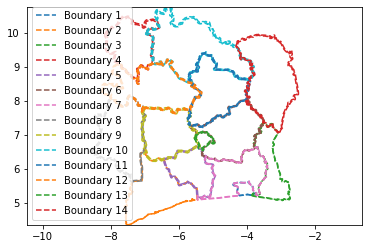

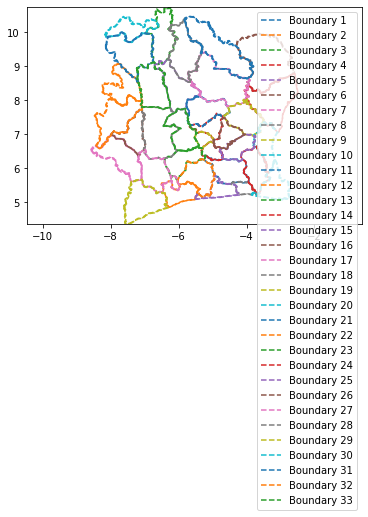

In [3]:
# load data
topoj = json.loads(urlopen('https://media.githubusercontent.com/media/wmgeolab/geoContrast/main/releaseData/{source}/{country}/ADM{level}/{source}-{country}-ADM{level}.topojson'.format(country=country, source=source1, level=level)).read())
coll1 = boundarytools.utils.topo2geoj(topoj)
boundaries1 = [boundarytools.uncertainty.NormalBoundary(f['geometry']) for f in coll1['features']]
boundarytools.utils.show_boundaries(boundaries1)

topoj = json.loads(urlopen('https://media.githubusercontent.com/media/wmgeolab/geoContrast/main/releaseData/{source}/{country}/ADM{level}/{source}-{country}-ADM{level}.topojson'.format(country=country, source=source2, level=level)).read())
coll2 = boundarytools.utils.topo2geoj(topoj)
boundaries2 = [boundarytools.uncertainty.NormalBoundary(f['geometry']) for f in coll2['features']]
boundarytools.utils.show_boundaries(boundaries2)

## Find a pair of equivalent boundaries in both sources

In [4]:
# params
res = 0.05
match_i = 1

def equal_feats(coll1, coll2, thresh=0.8):
    for feat1 in coll1['features']:
        bnd1 = boundarytools.uncertainty.NormalBoundary(feat1['geometry'])
        for feat2 in coll2['features']:
            bnd2 = boundarytools.uncertainty.NormalBoundary(feat2['geometry'])
            stats = bnd1.similarity(bnd2, resolution=res)
            if stats['equality'] >= thresh:
                print('found match:')
                print('--> feat1', feat1['properties'])
                print('--> feat2', feat2['properties'])
                print('=== similarity', stats)
                yield feat1,feat2

matches = equal_feats(coll1, coll2)
for i in range(match_i+1):
    feat1,feat2 = next(matches)

found match:
--> feat1 {'GID_0': 'CIV', 'NAME_0': "Côte d'Ivoire", 'GID_1': 'CIV.1_1', 'NAME_1': 'Abidjan', 'VARNAME_1': '', 'NL_NAME_1': '', 'TYPE_1': 'District autonome', 'ENGTYPE_1': 'Autonomous district', 'CC_1': '', 'HASC_1': 'CI.AB'}
--> feat2 {'Shape_Leng': 2.32410563403, 'Shape_Area': 0.174569791167, 'ADM1_FR': "District Autonome D'Abidjan", 'ADM1_PCODE': 'CI01', 'ADM1_REF': 'District Autonome DAbidjan', 'ADM1ALT1FR': '', 'ADM1ALT2FR': '', 'ADM0_FR': "Côte d'Ivoire", 'ADM0_PCODE': 'CI', 'date': '20111224', 'validOn': '20180706', 'validTo': None}
=== similarity {'equality': 0.9247311949729919, 'within': 0.9555555582046509, 'contains': 0.966292142868042}
found match:
--> feat1 {'GID_0': 'CIV', 'NAME_0': "Côte d'Ivoire", 'GID_1': 'CIV.13_1', 'NAME_1': 'Yamoussoukro', 'VARNAME_1': '', 'NL_NAME_1': '', 'TYPE_1': 'District autonome', 'ENGTYPE_1': 'Autonomous district', 'CC_1': '', 'HASC_1': 'CI.YM'}
--> feat2 {'Shape_Leng': 2.02176404773, 'Shape_Area': 0.169295606513, 'ADM1_FR': 'Dis

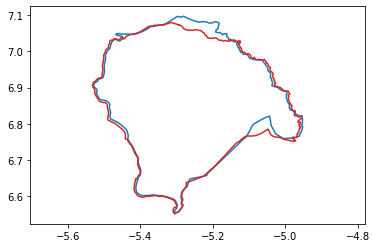

In [5]:
# show
d1 = {'type': 'FeatureCollection', 'features': [feat1]}
d2 = {'type': 'FeatureCollection', 'features': [feat2]}
boundarytools.utils.show_datasets(d1, d2)

## Calculate boundary deviations between sources

In [6]:
# params
SIGNED = True

# calc dists
dists = boundarytools.compare.boundary_distances(feat1['geometry'], feat2['geometry'], 0.005, signed_distances=SIGNED)
dists = np.array(dists)
print('distances', len(dists))

# fake the distribution to be +- around assumed mean of 0
if not SIGNED:
    dists = np.append(dists, -dists)

distances 409


## Calculate and compare source boundary metrics

In [7]:
# minimum line res
min1 = np.array(boundarytools.uncertainty._line_dists([feat1['geometry']])).min()
min2 = np.array(boundarytools.uncertainty._line_dists([feat2['geometry']])).min()
print('min line res:', source1, min1, 'VS', source2, min2)

# median line res
med1 = np.median( np.array(boundarytools.uncertainty._line_dists([feat1['geometry']])) )
med2 = np.median( np.array(boundarytools.uncertainty._line_dists([feat2['geometry']])) )
print('median line res:', source1, med1, 'VS', source2, med2)

# mean line res
mean1 = np.array(boundarytools.uncertainty._line_dists([feat1['geometry']])).mean()
mean2 = np.array(boundarytools.uncertainty._line_dists([feat2['geometry']])).mean()
print('mean line res:', source1, mean1, 'VS', source2, mean2)

# maximum line res
max1 = np.array(boundarytools.uncertainty._line_dists([feat1['geometry']])).max()
max2 = np.array(boundarytools.uncertainty._line_dists([feat2['geometry']])).max()
print('max line res:', source1, max1, 'VS', source2, max2)

min line res: gadm 0.0002912950219276327 VS CIV_CNTIG 0.0007248624420054731
median line res: gadm 0.005322925274405053 VS CIV_CNTIG 0.0016803604790507265
mean line res: gadm 0.006870394836588551 VS CIV_CNTIG 0.0018329683116314608
max line res: gadm 0.06660112176983542 VS CIV_CNTIG 0.012437777482018023


## Plot

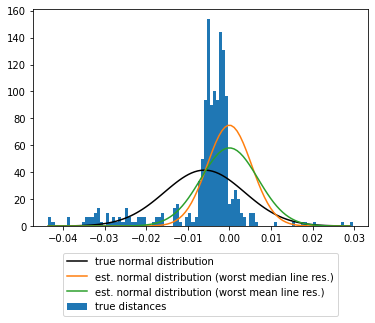

In [8]:
def plot():
    # first plot the true distance distribution
    import matplotlib.pyplot as plt
    ys,bins,patches = plt.hist(dists, bins=100, density=True, label='true distances') #, cumulative=True) #, range=(0,2e-09))
    xs = bins[:-1] # use only start of each bin as x value
    #plt.xscale('log')
    
    # add in normal dist
    import math
    def normpdf(x, mean, sd):
        var = float(sd)**2
        denom = (2*math.pi*var)**.5
        num = math.exp(-(float(x)-float(mean))**2/(2*var))
        return num/denom
    mean = dists.mean() # if we ignore the sign of the distances (ie no bias) this should be around 0
    std = dists.std()
    ypred = [normpdf(x, mean, std) for x in xs]
    plt.plot(xs, ypred, color='black', label='true normal distribution')

    # minimum line res
    #mean = 0
    #std = max(min1, min2) # normal line distribution
    #ypred = [normpdf(x, mean, std) for x in xs]
    #plt.plot(xs, ypred, label='est. normal distribution (worst minimum line res.)')
    
    # median line res
    mean = 0
    std = max(med1, med2) # normal line distribution
    ypred = [normpdf(x, mean, std) for x in xs]
    plt.plot(xs, ypred, label='est. normal distribution (worst median line res.)')
    
    # mean line res
    mean = 0
    std = max(mean1, mean2) # normal line distribution
    ypred = [normpdf(x, mean, std) for x in xs]
    plt.plot(xs, ypred, label='est. normal distribution (worst mean line res.)')
    
    # maximum line res
    #mean = 0
    #std = max(max1, max2) # normal line distribution
    #ypred = [normpdf(x, mean, std) for x in xs]
    #plt.plot(xs, ypred, label='est. normal distribution (worst maximum line res.)')
    
    # show
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))
    plt.show()
    
plot()

In [9]:
uncert = boundarytools.uncertainty.NormalBoundary(feat2['geometry']).precision_surface(resolution=0.005)

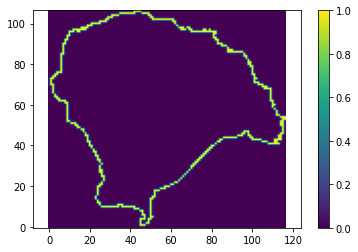

In [10]:
boundarytools.utils.show_surface(uncert)